# Notebook : 02_model_training_unet.ipynb
- Objectif : entraîner un premier modèle U-Net sur Cityscapes (8 classes) avec pipeline MLOps
# 1 - Imports & préparation

In [ ]:
import sys
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

import mlflow
mlflow.set_tracking_uri("file:./mlruns")

from dotenv import load_dotenv
load_dotenv()

False

In [2]:
# Remonter à la racine du projet
project_root = Path("..").resolve()

# Ajouter src/ au PYTHONPATH
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

In [3]:
from utils.utils import plot_history

# 2 - Unet
## 2.1 - Chargement des fonctions d'entraînement

In [4]:
from model_training.train_unet import train_unet_model_from_npz
from utils.utils import plot_history

## 2.2 - Chargement des données .npz

In [5]:
print("[INFO] Chargement des fichiers .npz...")
data_dir = project_root / "data" / "processed" / "augmented"
train = np.load(data_dir / "train.npz")
val   = np.load(data_dir / "val.npz")

X_train, Y_train = train["X"], train["Y"]
X_val, Y_val     = val["X"], val["Y"]

print(f"✅ Train shape : {X_train.shape} / {Y_train.shape}")
print(f"✅ Val shape   : {X_val.shape} / {Y_val.shape}")

[INFO] Chargement des fichiers .npz...
✅ Train shape : (4000, 256, 256, 3) / (4000, 256, 256)
✅ Val shape   : (500, 256, 256, 3) / (500, 256, 256)


## 2.2 - Paramètres

In [ ]:
params_test = {
    'img_size': (256, 256),
    'epochs': 1,
    'batch_size': 4,
    'use_early_stopping': True,
    'force_retrain': False
}

params_prod = {
    'img_size': (256, 256),
    'epochs': 40,
    'batch_size': 8,
    'use_early_stopping': True,
    'force_retrain': False
}

# 3 - Entraînements
## 3.1 - Test rapide


🔁 Entraînement rapide (TEST)...
✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ train_unet_model_from_npz appelé
[INFO] Initialisation du modèle UNet Mini...
✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ unet_mini appelé





1000/1000 [==============================] - 591s 589ms/step - loss: 1.1911 - accuracy: 0.4829 - iou_score: 0.3265 - dice_coef: 0.4829 - val_loss: 1.0074 - val_accuracy: 0.5388 - val_iou_score: 0.3796 - val_dice_coef: 0.5388


c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\venv_p8\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


[LOG] ➤ plot_history appelé


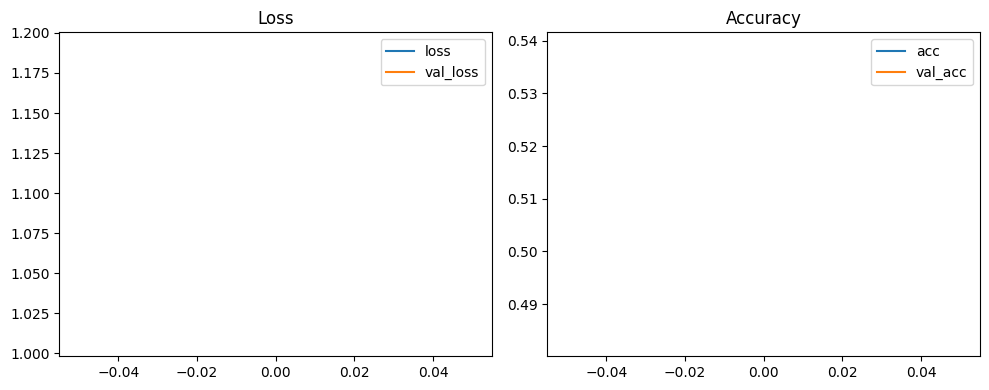

2025/04/17 15:17:59 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmp6xz00okf\model\data\model\assets


INFO:tensorflow:Assets written to: C:\Users\motar\AppData\Local\Temp\tmp6xz00okf\model\data\model\assets
2025/04/17 15:18:09 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\motar\AppData\Local\Temp\tmp6xz00okf\model, flavor: tensorflow). Fall back to return ['tensorflow==2.15.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\venv_p8\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [7]:
print("\n🔁 Entraînement rapide (TEST)...")
model_test, history_test = train_unet_model_from_npz(
    X_train, Y_train, X_val, Y_val,
    **params_test
)

### 3.1.1 - Résumé du modèle et courbe d'apprentissage

In [ ]:
print("\n🧠 Résumé du modèle UNet Mini (TEST) :")
model_test.summary()
from pathlib import Path
output_dir = project_root / "outputs" / "figures"
output_dir.mkdir(parents=True, exist_ok = True)

plot_history(history_test, output_dir / "history_test.png")


🧠 Résumé du modèle UNet Mini (TEST) :
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 32)         896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 32)         9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 32)         0         ['conv2d_1[0][0]']            
 D)                                                    

### 3.1.2 - courbes IoU et Dice

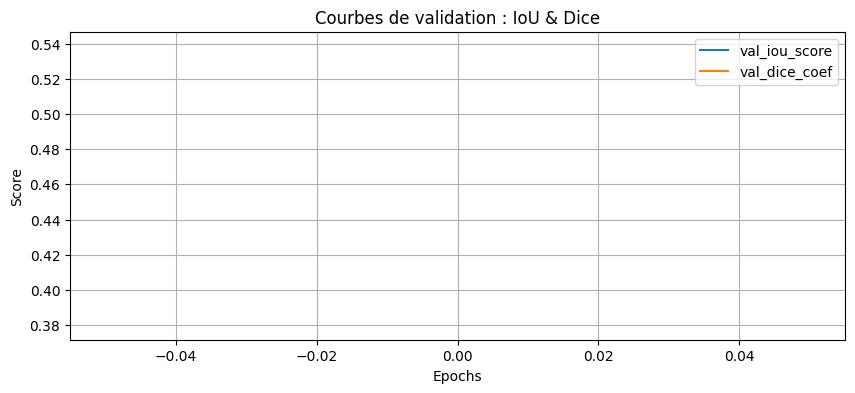

In [10]:
plt.figure(figsize=(10,4))
plt.plot(history_test['val_iou_score'], label='val_iou_score')
plt.plot(history_test['val_dice_coef'], label='val_dice_coef')
plt.title('Courbes de validation : IoU & Dice')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()

## 3.2 - Entraînement PROD complet

In [ ]:
print("\n🚀 Entraînement complet (PROD)...")
model_prod, history_prod = train_unet_model_from_npz(
    X_train, Y_train, X_val, Y_val,
    **params_prod
)


🚀 Entraînement complet (PROD)...
✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ train_unet_model_from_npz appelé
[INFO] Initialisation du modèle UNet Mini...
✅ Serveur MLflow déjà actif sur http://127.0.0.1:5000
[LOG] ➤ unet_mini appelé
Epoch 1/40
500/500 [==============================] - 632s 1s/step - loss: 1.1999 - accuracy: 0.4842 - iou_score: 0.3247 - dice_coef: 0.4842 - val_loss: 1.0096 - val_accuracy: 0.5411 - val_iou_score: 0.3746 - val_dice_coef: 0.5407
Epoch 2/40


c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P08\P08_segmentation\venv_p8\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


500/500 [==============================] - 622s 1s/step - loss: 0.9986 - accuracy: 0.5556 - iou_score: 0.3895 - dice_coef: 0.5556 - val_loss: 0.9393 - val_accuracy: 0.5654 - val_iou_score: 0.3984 - val_dice_coef: 0.5648
Epoch 3/40
500/500 [==============================] - 614s 1s/step - loss: 0.9386 - accuracy: 0.5779 - iou_score: 0.4126 - dice_coef: 0.5779 - val_loss: 0.9037 - val_accuracy: 0.5685 - val_iou_score: 0.3999 - val_dice_coef: 0.5682
Epoch 4/40
500/500 [==============================] - 617s 1s/step - loss: 0.9139 - accuracy: 0.5849 - iou_score: 0.4190 - dice_coef: 0.5849 - val_loss: 0.9685 - val_accuracy: 0.5543 - val_iou_score: 0.3890 - val_dice_coef: 0.5538
Epoch 5/40
500/500 [==============================] - 630s 1s/step - loss: 0.8866 - accuracy: 0.5951 - iou_score: 0.4301 - dice_coef: 0.5951 - val_loss: 0.8712 - val_accuracy: 0.5904 - val_iou_score: 0.4281 - val_dice_coef: 0.5896
Epoch 6/40
500/500 [==============================] - 624s 1s/step - loss: 0.8647 - acc

### 3.2.1 - Résumé final du modèle + graphe

In [ ]:
print("\n🧠 Résumé du modèle UNet Mini (PROD) :")
model_prod.summary()
plot_history(history_prod, output_dir / "history_prod.png")

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(history_prod['val_iou_score'], label='val_iou_score')
plt.plot(history_prod['val_dice_coef'], label='val_dice_coef')
plt.title('Courbes de validation : IoU & Dice (PROD)')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()